In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks (or box) on a frame to get and refine _masklets_ (spatio-temporal masks)
- propagating clicks (or box) to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/sam2/blob/main/notebooks/video_predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Set-up

In [2]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cpu


/home/joseph/anaconda3/envs/sam2/lib/python3.12/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Load Util Functions

In [4]:
from video_labeller_utils import *

### Loading the SAM 2 video predictor

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

In [5]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/home/joseph/Documents/project/videos/foosball_videos/foosman_rotation_data_set/Test_0/Top View/condensed_jpg/0"

# scan all the JPEG frame names in this directory
frame_names = get_frame_name_list(video_dir)


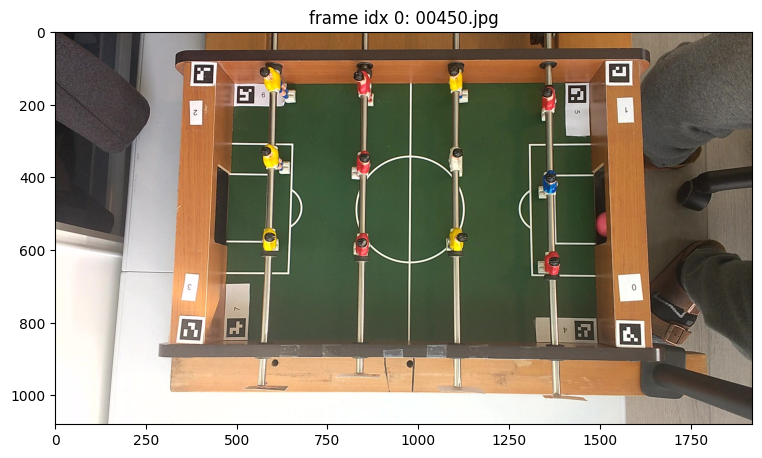

In [6]:
# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
frame_title = f"frame idx {frame_idx}: " + frame_names[frame_idx]
plt.title(frame_title)
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

#### Initialize the inference state

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [7]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|███████████████████| 180/180 [00:08<00:00, 20.02it/s]


## Initialize the detection masks

In [8]:
# add the foosball men
frame_idx = 0
numFoosmen = 4

# rod_9_foosman_0_clicks = [[1373,661],[1375,636], [1361,612], [1338, 648]]
# rod_9_foosman_1_clicks = [[1364,436],[1366,405],[1340,443]]
# rod_9_foosman_2_clicks = [[1360,155], [1360,203], [1343,242], [1343,242], [1340, 226], [1367, 168]]

rod_9_foosman_0_clicks = [[1362,633],[1342, 650]]
rod_9_foosman_1_clicks = [[1363,406],[1340, 441]]
rod_9_foosman_2_clicks = [[1356,171], [1344,242]]

In [9]:
num_frames = len(frame_names)
num_items = 3
label_array = np.zeros((num_frames, num_items, 4))

In [10]:
id_list_0 = [0, 1, 2]
position_group_0 = [rod_9_foosman_0_clicks, rod_9_foosman_1_clicks, rod_9_foosman_2_clicks]
num_groups = 1
id_super_list = [id_list_0]
position_super_list = [position_group_0]

## Run bounding box detection

In [11]:
video_segments_super_list = {}
prompts = {}

for group_idx in range(0, num_groups):
    print("labelling group ", group_idx)
    predictor.reset_state(inference_state)
    positions = position_super_list[group_idx]
    id_list = id_super_list[group_idx]
    out_obj_ids, out_mask_logits = initialize_labels(id_list, positions, predictor, inference_state, frame_idx, prompts)
    video_segments = propagate_in_video(predictor, inference_state)
    video_segments_super_list[group_idx] = video_segments
    obtain_bounding_boxes(frame_names, video_segments, label_array)

labelling group  0


/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/git/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/git/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 180/180 [00:48<00:00,  3.72it/s]
/media/joseph/BC5EE56A5EE51E40/Users/littl/Documents/U of T M Eng/Fall 2024/CSC2529 Computational Imaging/project/git/sam2/notebooks/video_labeller_utils.py:110: RuntimeWarning: invalid value encountered in divide
  deviations 

In [12]:
negative_coords = np.argwhere(label_array == -1)
print(negative_coords)

[]


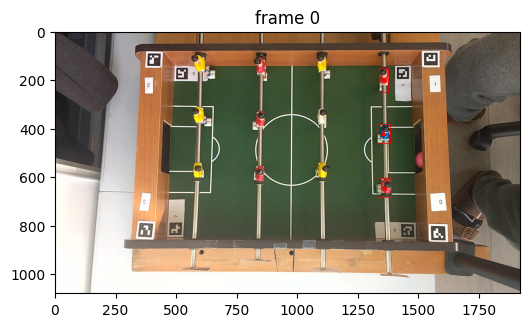

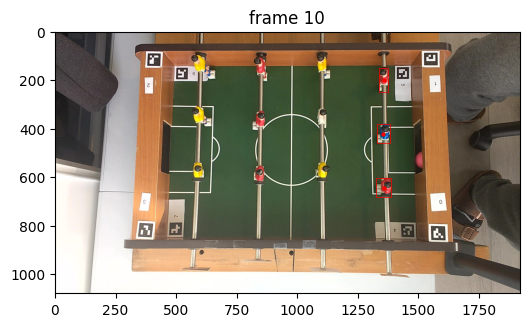

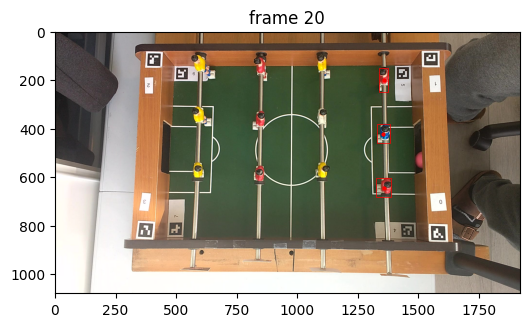

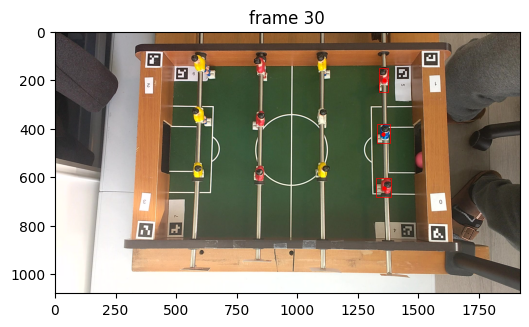

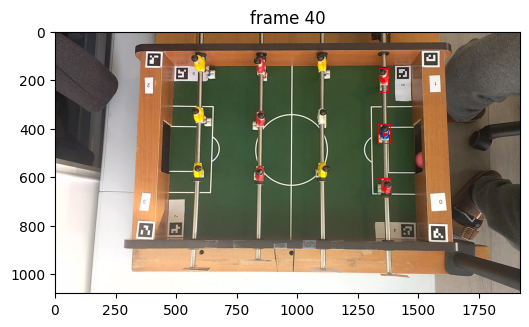

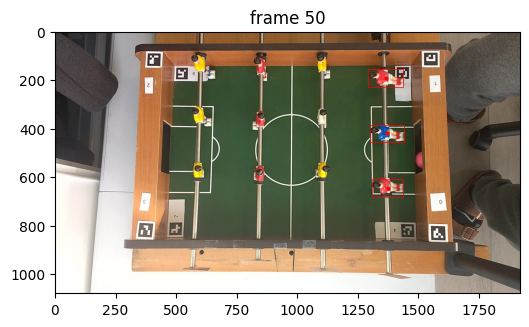

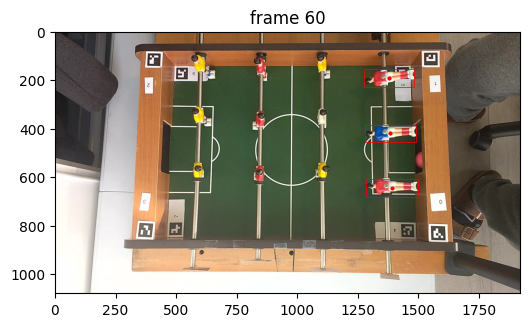

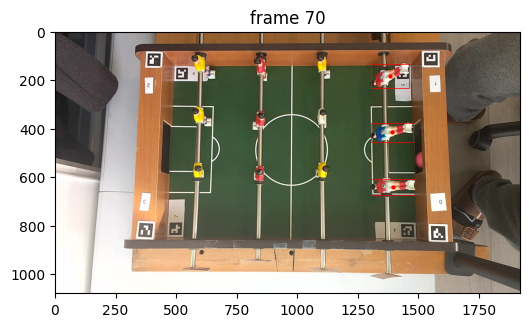

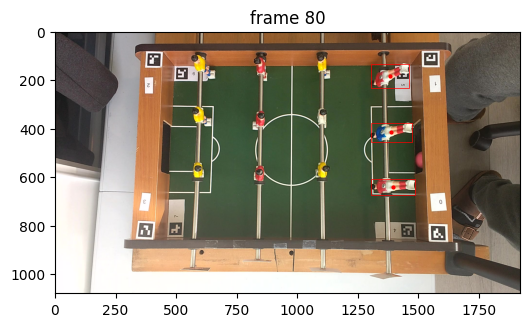

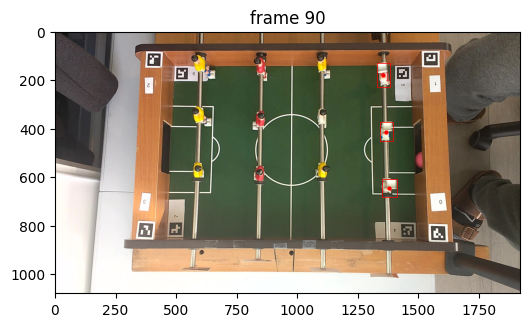

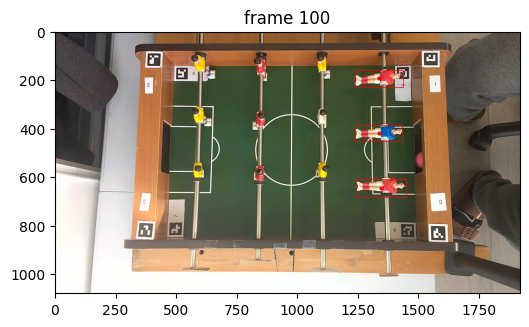

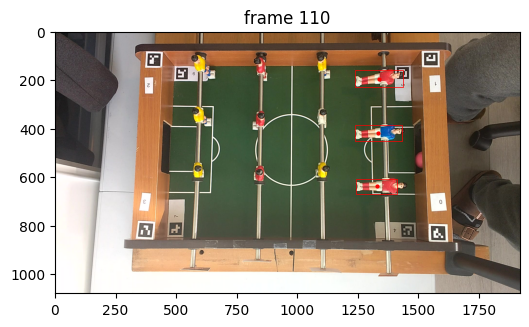

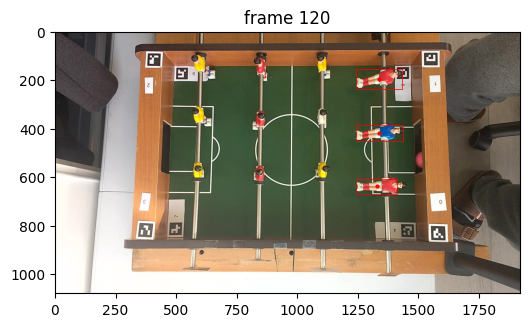

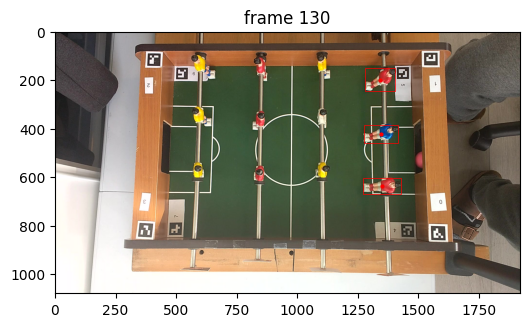

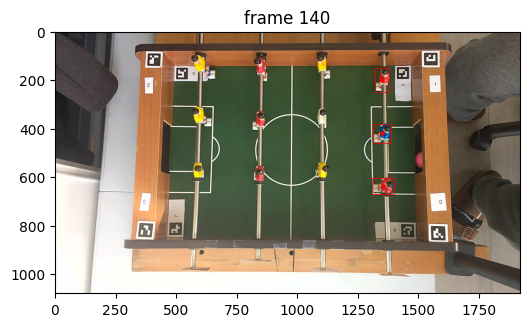

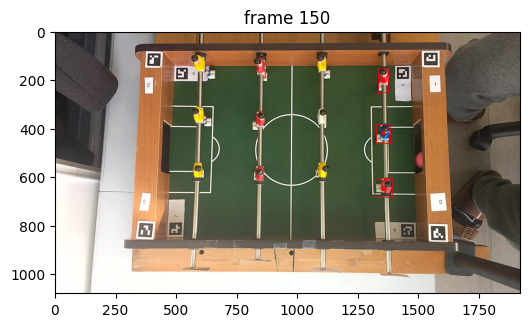

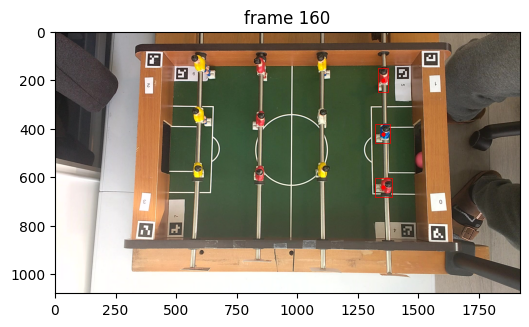

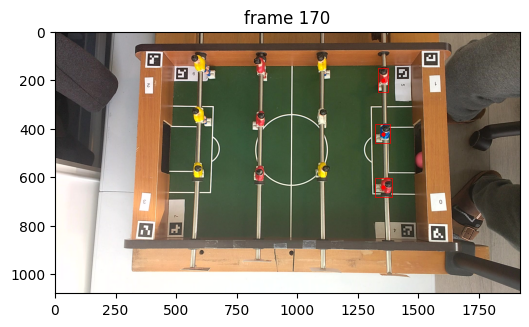

In [13]:
# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    frame_labels = label_array[out_frame_idx]
    for object_idx in range(len(frame_labels)):
        label = frame_labels[object_idx]
        cx = label[0]
        cy = label[1]
        w = label[2]
        h = label[3]
        # negative bounding box - not detected
        if(cx >= 0):
            draw_bounding_box_from_scaled_label(cx, cy, w, h, (1,1), plt.gca())
            plt.plot(cx,cy,'ro', markersize=2)

## Linear regression with ground truth data


['top_view_frame_numbers', 'top_view_rod_thetas_filtered', 'top_view_times']


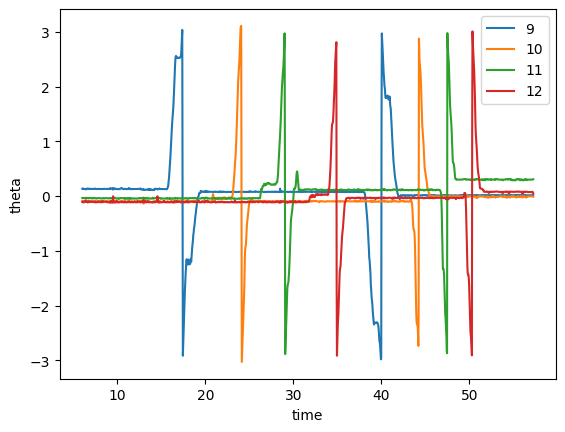

In [14]:

ground_truth_data_folder = "/home/joseph/Documents/project/videos/foosball_videos/foosman_rotation_data_set/Test_0/Top View"
ground_truth_file_name = "top_view_rod_theta_data.out.npz"

outfile = os.path.join(ground_truth_data_folder,ground_truth_file_name)

npzfile = np.load(outfile)

print(sorted(npzfile.files))
top_view_frame_numbers_from_file = npzfile['top_view_frame_numbers']
top_view_times_from_file = npzfile['top_view_times']
top_view_rod_thetas_filtered_from_file = npzfile['top_view_rod_thetas_filtered']

plt.close("all")
plt.plot(top_view_times_from_file, top_view_rod_thetas_filtered_from_file, label=[9,10,11,12])

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

In [15]:
# Note - for the top video view data set, for foosman tracking we start at Frame 250
# Previously in the rotation estimation data, we aligned it to Frame 204
top_view_alignment_frame = 204
top_view_detection_start_frame = 400


In [16]:
# Alignments
# copied from rotation_measurement_test notebook - [as code clean up should save to npz file]
rod_9_alignment_offsets = np.array([0, -2.87920689, -3.83271611]) * np.pi / 180
rod_10_alignment_offsets = np.array([0, -6.12766447, -13.74226049]) * np.pi / 180
rod_11_alignment_offsets = np.array([0, 1.58121192, -15.37725851]) * np.pi / 180
rod_12_alignment_offsets = np.array([0, -12.24342305, -18.88451866]) * np.pi / 180

In [17]:
print(top_view_rod_thetas_filtered_from_file.shape)

(1508, 4)


In [18]:
folder_0_start_frame = 450 - top_view_alignment_frame
folder_0_end_frame = 629 - top_view_alignment_frame + 1

In [19]:
print(folder_0_start_frame)
print(folder_0_end_frame)

246
426


In [20]:
rod_9_ground_truth_data_thetas = top_view_rod_thetas_filtered_from_file[folder_0_start_frame:folder_0_end_frame,0]
rod_9_ground_truth_times = top_view_times_from_file[folder_0_start_frame:folder_0_end_frame]

rod_9_ground_truth_data_theta_0 = rod_9_ground_truth_data_thetas + rod_9_alignment_offsets[0]
rod_9_ground_truth_data_theta_1 = rod_9_ground_truth_data_thetas + rod_9_alignment_offsets[1]
rod_9_ground_truth_data_theta_2 = rod_9_ground_truth_data_thetas + rod_9_alignment_offsets[2]

rod_9_ground_truth_data_thetas = np.stack([rod_9_ground_truth_data_theta_0, rod_9_ground_truth_data_theta_1, rod_9_ground_truth_data_theta_2], axis=1)


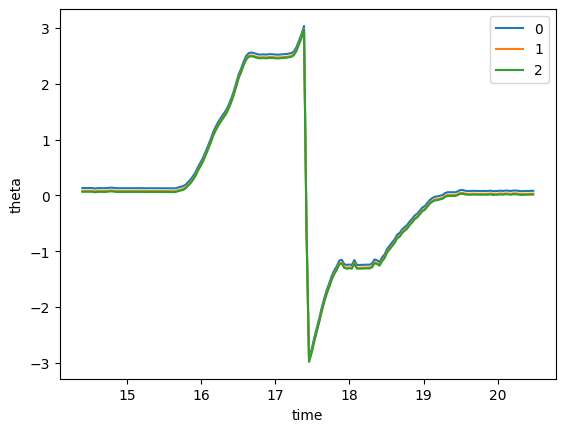

In [21]:
plt.close("all")
plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_data_thetas, label=[0,1,2])

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

(180, 3, 4)
(180, 4)
(180,)
(180,)
(180,)
(180,)


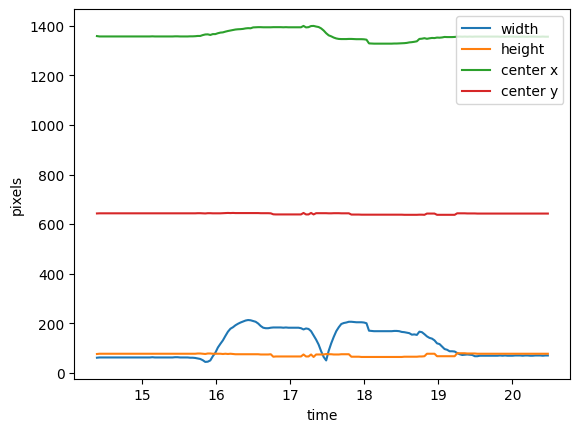

In [22]:
print(label_array.shape)

foos_0_bounding_boxes = label_array[:,0,:]
print(foos_0_bounding_boxes.shape)
foos_0_x_boxes = foos_0_bounding_boxes 


cx = foos_0_bounding_boxes[:,0]
cy = foos_0_bounding_boxes[:,1]
w = foos_0_bounding_boxes[:,2]
h = foos_0_bounding_boxes[:,3]

print(cx.shape)
print(cy.shape)
print(w.shape)
print(h.shape)

plt.close("all")
# plt.plot(rod_9_ground_truth_times, np.reshape([w, h], (-1,2)), label=["width", "height"])
# plt.plot(rod_9_ground_truth_times, np.reshape([cx, cy], (-1,2)), label=["cx", "cy"])

plt.plot(rod_9_ground_truth_times, w, label="width")
plt.plot(rod_9_ground_truth_times, h, label="height")
plt.plot(rod_9_ground_truth_times, cx, label="center x")
plt.plot(rod_9_ground_truth_times, cy, label="center y")

plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()


1360.9666666666667


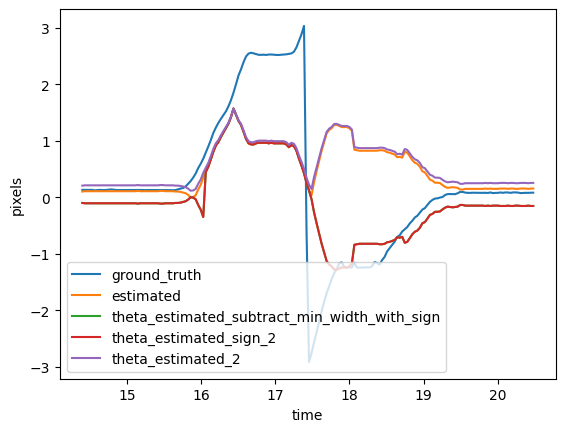

In [122]:
mean_cx = np.mean(cx)
print(mean_cx)

x0_vals = cx - w/2
x1_vals = cx + w/2

min_x0 = np.min(x0_vals)
max_x1 = np.max(x1_vals)

estimated_rod_center = (min_x0 + max_x1)/2
min_width = np.min(w)

# naive angle estimation
# accounting for minimum bounding box width
theta_estimated = np.arcsin((w - min_width)/ (max_w - min_width))
theta_estimated_2 = np.arcsin((w - min_width/2)/ (max_w - min_width/2))

# using center and max range computation
R = (max_x1 - min_x0)/2 - min_width/2
# theta_estimate_2 = np.arcsin((w - min_width/2)/ R)

# use sign
theta_signs = np.sign(cx - estimated_rod_center)
# if box is longer to right of rod center -> positive
# if box is longer to left of rod center -> negative
theta_estimated_subtract_min_width_with_sign = np.multiply(theta_estimated, theta_signs)

left_side_widths = np.abs(x0_vals - estimated_rod_center)
right_side_widths = np.abs(x1_vals - estimated_rod_center)

signs_2 = np.sign(right_side_widths - left_side_widths)
theta_estimated_sign_2 = np.multiply(theta_estimated_subtract_min_width, signs_2)

plt.close("all")
# plt.plot(rod_9_ground_truth_times, np.reshape([w, h], (-1,2)), label=["width", "height"])
# plt.plot(rod_9_ground_truth_times, np.reshape([cx, cy], (-1,2)), label=["cx", "cy"])

plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_data_thetas[:,0], label="ground_truth")
plt.plot(rod_9_ground_truth_times, theta_estimated, label="estimated")
plt.plot(rod_9_ground_truth_times, theta_estimated_subtract_min_width_with_sign, label="theta_estimated_subtract_min_width_with_sign")
plt.plot(rod_9_ground_truth_times, theta_estimated_sign_2, label="theta_estimated_sign_2")
plt.plot(rod_9_ground_truth_times ,theta_estimated_2, label="theta_estimated_2")

# ground_truth_mod_90 = np.mod(rod_9_ground_truth_data_thetas[:,0], np.pi/2)
# plt.plot(rod_9_ground_truth_times, ground_truth_mod_90, label="ground_truth_mod_90")

plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()



In [30]:
print(np.max(theta_estimated_subtract_min_width))
print(np.min(theta_estimated_subtract_min_width))

1.5707963267948966
0.0


1371.0


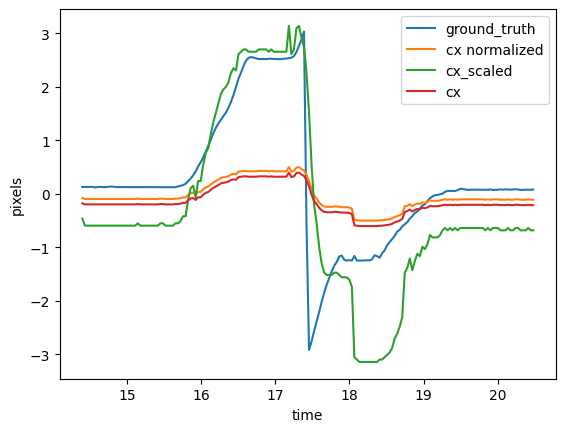

In [50]:
mean_cx = estimated_rod_center
print(mean_cx)
cx_max = np.max(cx)
cx_min = np.min(cx)
cx_mid = (cx_max + cx_min)/2
cx_range = np.abs(cx_max - cx_min)

cx_normalized = (cx - cx_mid) / cx_range

cx_scaled = (cx_normalized) * 2 * np.pi

cx_2 = (cx - estimated_rod_center) / cx_range


plt.close("all")

plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_data_thetas[:,0], label="ground_truth")
plt.plot(rod_9_ground_truth_times, cx_normalized, label="cx normalized")
plt.plot(rod_9_ground_truth_times, cx_scaled, label="cx_scaled")
plt.plot(rod_9_ground_truth_times, cx_2, label="cx")

plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()



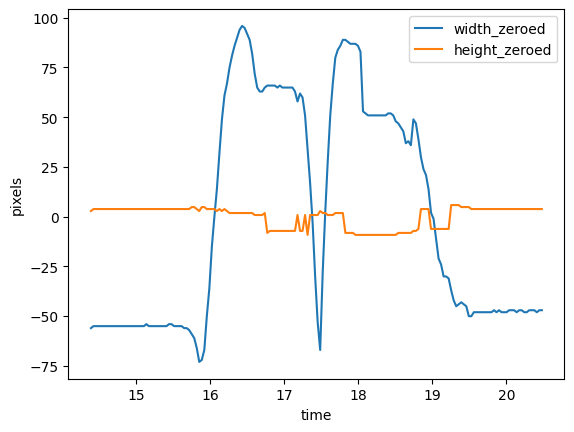

In [117]:
plt.close("all")
# plt.plot(rod_9_ground_truth_times, np.reshape([w, h], (-1,2)), label=["width", "height"])
# plt.plot(rod_9_ground_truth_times, np.reshape([cx, cy], (-1,2)), label=["cx", "cy"])

width_zeroed = w - np.mean(w)

height_zeroed = h - np.mean(h)

plt.plot(rod_9_ground_truth_times, width_zeroed, label="width_zeroed")
plt.plot(rod_9_ground_truth_times, height_zeroed, label="height_zeroed")

plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()

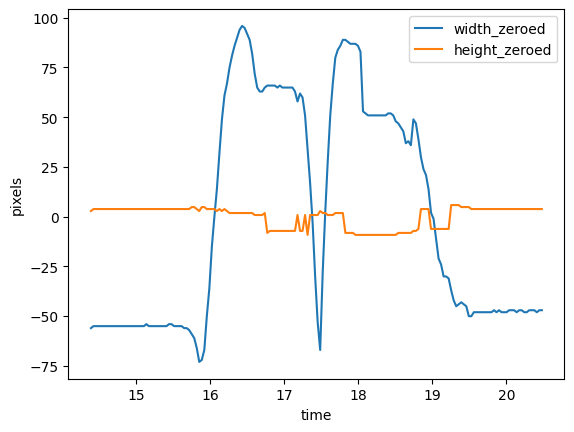

In [122]:
plt.close("all")
# plt.plot(rod_9_ground_truth_times, np.reshape([w, h], (-1,2)), label=["width", "height"])
# plt.plot(rod_9_ground_truth_times, np.reshape([cx, cy], (-1,2)), label=["cx", "cy"])

width_zeroed_scaled = w - np.mean(w)
height_zeroed_scaled = h - np.mean(h)

plt.plot(rod_9_ground_truth_times, width_zeroed, label="width_zeroed")
plt.plot(rod_9_ground_truth_times, height_zeroed, label="height_zeroed")

plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()

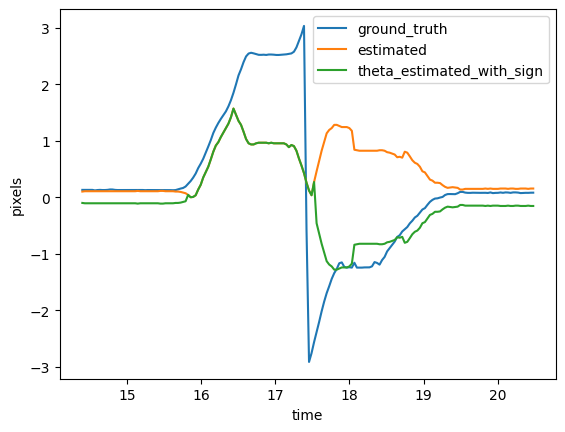

In [54]:
# using center x to infer sign
# theta_estimated = np.arcsin((w)/ max_w)

sign = np.where(cx > mean_cx, 1, -1)
theta_estimated_with_sign = np.multiply(theta_estimated, sign)

# sign_calibrated = 

plt.close("all")

plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_data_thetas[:,0], label="ground_truth")
plt.plot(rod_9_ground_truth_times, theta_estimated, label="estimated")
plt.plot(rod_9_ground_truth_times, theta_estimated_with_sign, label="theta_estimated_with_sign")


plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()


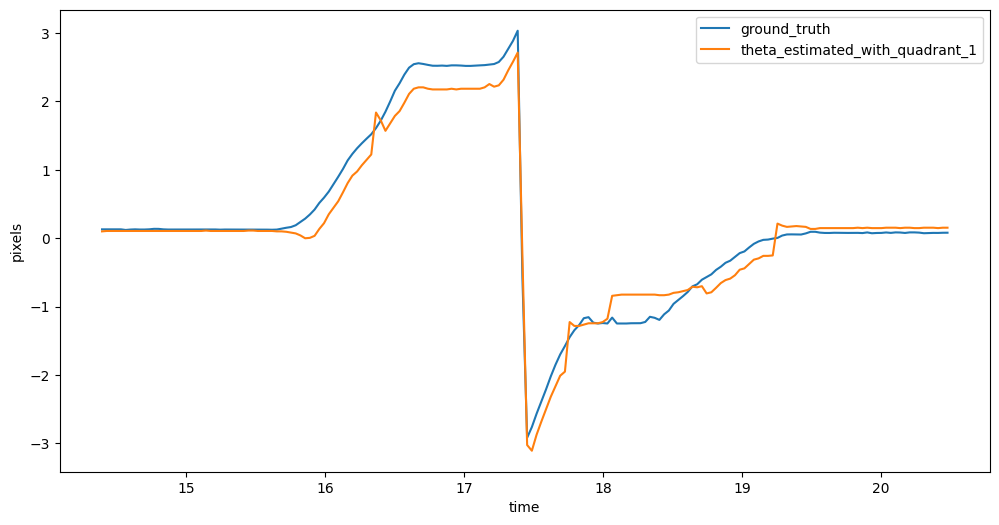

In [55]:
# assuming we detected the quadrants of the foosman
rod_9_ground_truth_0 = rod_9_ground_truth_data_thetas[:,0]
# theta_estimated = np.arcsin((w)/ max_w)
sign = np.where(cx > mean_cx, 1, -1)
theta_estimated_with_sign = np.multiply(theta_estimated, sign)

quadrant_signs_0 = np.round((rod_9_ground_truth_0 + np.pi) / np.pi) - 1
# quadrant 0, 1, 2, 3 correspond to 0-90, 90-180, -180 to -90, -90 to 0
quadrant_signs = [0,1,-1,0] # for quadrant 0, 1, 2, 3

quadrants = np.zeros(rod_9_ground_truth_0.shape)
quad_1_idx = np.argwhere(rod_9_ground_truth_0 > np.pi/2)
quadrants[quad_1_idx] = 1

quad_3_idx = np.argwhere(rod_9_ground_truth_0 < 0)
quadrants[quad_3_idx] = 3
quad_2_idx = np.argwhere(rod_9_ground_truth_0 < -np.pi/2)
quadrants[quad_2_idx] = 2


quadrant_sign_values = np.zeros(rod_9_ground_truth_0.shape)
quadrant_sign_values[quad_1_idx] = 1
quadrant_sign_values[quad_3_idx] = 0
quadrant_sign_values[quad_2_idx] = -1

quadrant_theta_sign_values = np.ones(rod_9_ground_truth_0.shape)
quadrant_theta_sign_values[quad_1_idx] = -1
quadrant_theta_sign_values[quad_3_idx] = 1
quadrant_theta_sign_values[quad_2_idx] = 1



theta_estimated_with_quadrant = quadrant_sign_values * np.pi + np.multiply(theta_estimated, quadrant_theta_sign_values)

theta_estimated_with_quadrant_1 = np.copy(theta_estimated)
theta_estimated_with_quadrant_1[quad_1_idx] = np.pi - theta_estimated[quad_1_idx]
theta_estimated_with_quadrant_1[quad_3_idx] = -theta_estimated[quad_3_idx]
theta_estimated_with_quadrant_1[quad_2_idx] = -np.pi + theta_estimated[quad_2_idx]



# theta_estimated_with_quadrant_sign = quadrant_sign_values * np.pi/2 + theta_estimated_with_sign

plt.close("all")
plt.figure(figsize=(12, 6))

plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_0, label="ground_truth")
# plt.plot(rod_9_ground_truth_times, theta_estimated, label="estimated")
# # plt.plot(rod_9_ground_truth_times,quadrant_signs_0, label="quadrant_signs_0")
# plt.plot(rod_9_ground_truth_times,quadrants, label="quadrants")
# # plt.plot(rod_9_ground_truth_times,quadrant_signs_0, label="quadrant_sign_values")
# plt.plot(rod_9_ground_truth_times, theta_estimated_with_quadrant, label="theta estimated with quadrant")
plt.plot(rod_9_ground_truth_times, theta_estimated_with_quadrant_1, label="theta_estimated_with_quadrant_1")
# plt.plot(rod_9_ground_truth_times, theta_estimated_with_quadrant_sign, label="theta_estimated_with_quadrant_sign")


plt.xlabel("time") 
plt.ylabel("pixels") 
plt.legend()
plt.show()


Siegel Slopes Results:
Robust Slope: 0.7409
Robust Intercept: 0.0128

Regular Linear Regression Results:
Regular Slope: 1.0727
Regular Intercept: 0.0661
R-squared: 0.975158


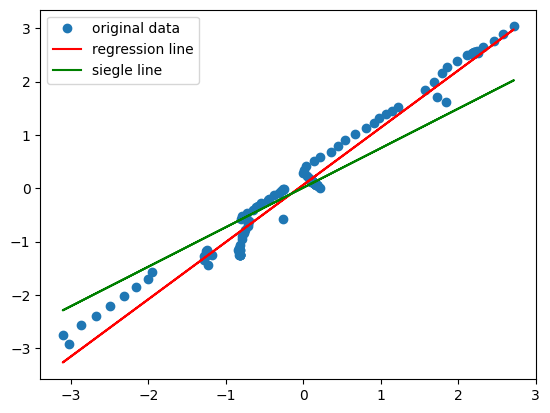

In [56]:
# curve fitting
# try numpy linear regression
from scipy import stats
x = theta_estimated_with_quadrant_1
y = rod_9_ground_truth_0
res = stats.linregress(x, y)

# Calculate Siegel slopes
slope_siegel, intercept_siegel = stats.siegelslopes(x, y)

print("Siegel Slopes Results:")
print(f"Robust Slope: {slope_siegel:.4f}")
print(f"Robust Intercept: {intercept_siegel:.4f}")

print("\nRegular Linear Regression Results:")
print(f"Regular Slope: {res.slope:.4f}")
print(f"Regular Intercept: {res.intercept:.4f}")

print(f"R-squared: {res.rvalue**2:.6f}")
# Plot the data along with the fitted line:
plt.plot(x, y, 'o', label='original data')
plt.plot(x, res.intercept + res.slope*x, 'r', label='regression line')
plt.plot(x, intercept_siegel + slope_siegel*x, 'g', label='siegle line')
plt.legend()
plt.show()





In [57]:
m, c = np.polyfit(x, y, 1)
print(m, c)



1.07274407616094 0.06609495917759202


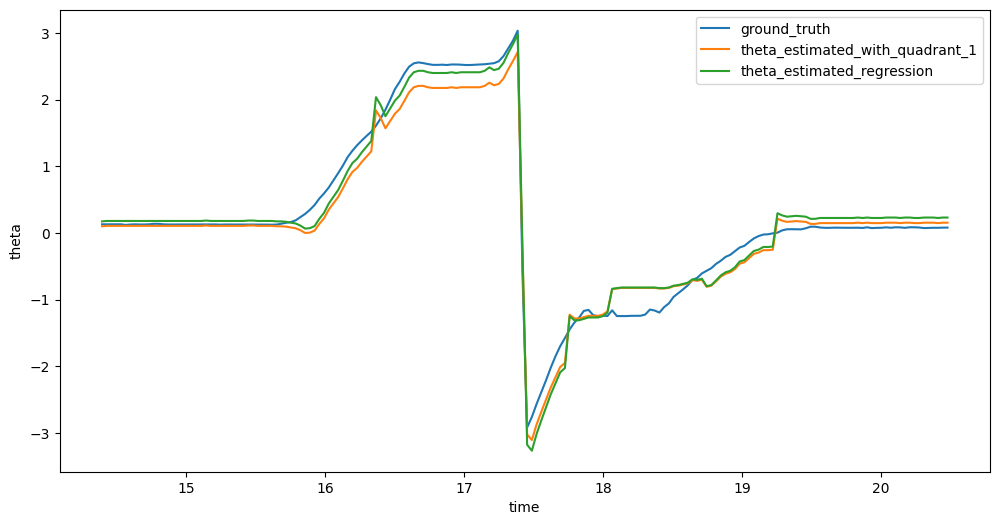

In [120]:
plt.close("all")
plt.figure(figsize=(12, 6))

plt.plot(rod_9_ground_truth_times, rod_9_ground_truth_0, label="ground_truth")
# plt.plot(rod_9_ground_truth_times, theta_estimated, label="estimated")
# # plt.plot(rod_9_ground_truth_times,quadrant_signs_0, label="quadrant_signs_0")
# plt.plot(rod_9_ground_truth_times,quadrants, label="quadrants")
# # plt.plot(rod_9_ground_truth_times,quadrant_signs_0, label="quadrant_sign_values")
# plt.plot(rod_9_ground_truth_times, theta_estimated_with_quadrant, label="theta estimated with quadrant")
plt.plot(rod_9_ground_truth_times, theta_estimated_with_quadrant_1, label="theta_estimated_with_quadrant_1")

theta_estimated_regression = res.intercept + res.slope*theta_estimated_with_quadrant_1
plt.plot(rod_9_ground_truth_times, theta_estimated_regression, label="theta_estimated_regression")


plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()


In [ ]:
error_quadrant_estimation =  

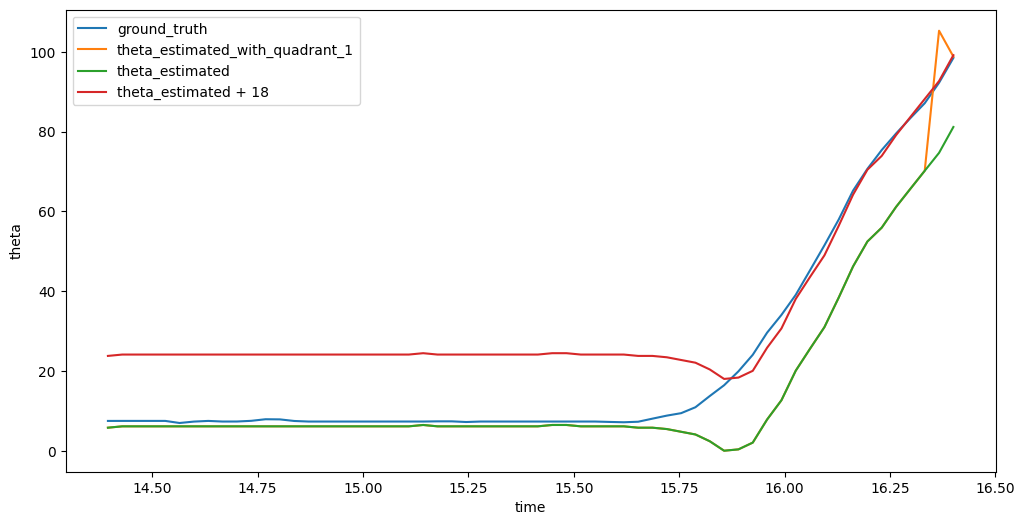

In [73]:

plt.close("all")
plt.figure(figsize=(12, 6))

sample_start=0
sample_end=60

theta_estimated_tuned = np.arcsin((w - min_width)/ (max_w - min_width))

time_sample = rod_9_ground_truth_times[sample_start:sample_end]
ground_truth_sample = rod_9_ground_truth_0[sample_start:sample_end] * 180 / np.pi
quadrant_estimation_sample = theta_estimated_with_quadrant_1[sample_start:sample_end] * 180 / np.pi
theta_estimated_sample = theta_estimated[sample_start:sample_end] * 180 / np.pi

plt.plot(time_sample, ground_truth_sample, label="ground_truth")
plt.plot(time_sample, quadrant_estimation_sample, label="theta_estimated_with_quadrant_1")
plt.plot(time_sample, theta_estimated_sample, label="theta_estimated")

offset= 18
plt.plot(time_sample, theta_estimated_sample + offset, label=f"theta_estimated + {offset}")

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

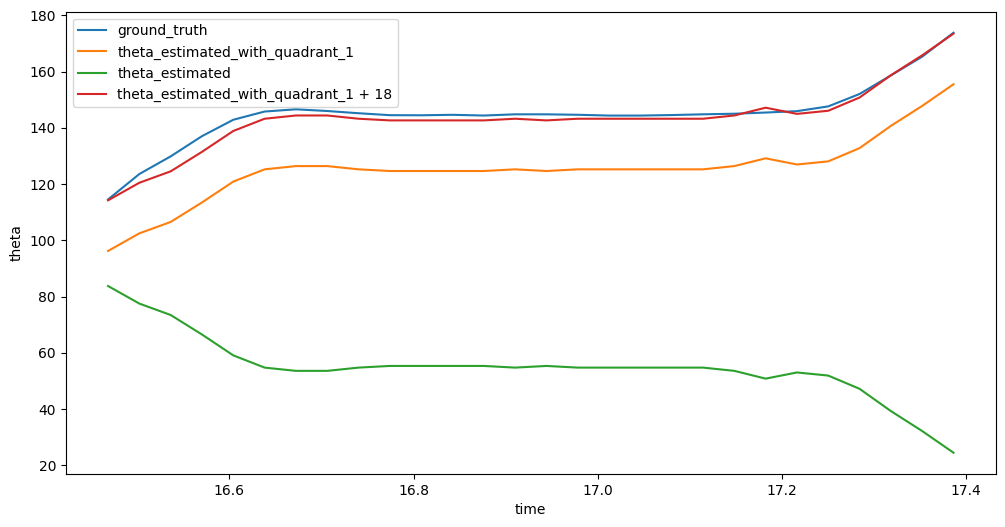

In [85]:
plt.close("all")
plt.figure(figsize=(12, 6))

sample_start=61
sample_end=89

theta_estimated_tuned = np.arcsin((w - min_width)/ (max_w - min_width))

time_sample = rod_9_ground_truth_times[sample_start:sample_end]
ground_truth_sample = rod_9_ground_truth_0[sample_start:sample_end] * 180 / np.pi
quadrant_estimation_sample = theta_estimated_with_quadrant_1[sample_start:sample_end] * 180 / np.pi
theta_estimated_sample = theta_estimated[sample_start:sample_end] * 180 / np.pi

plt.plot(time_sample, ground_truth_sample, label="ground_truth")
plt.plot(time_sample, quadrant_estimation_sample, label="theta_estimated_with_quadrant_1")
plt.plot(time_sample, theta_estimated_sample, label="theta_estimated")

offset= 18
plt.plot(time_sample, quadrant_estimation_sample + offset, label=f"theta_estimated_with_quadrant_1 + {offset}")

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

In [87]:
print(rod_9_ground_truth_times.shape)
print(min(rod_9_ground_truth_times))
print(max(rod_9_ground_truth_times))

(180,)
14.394992068887378
20.479288465896214


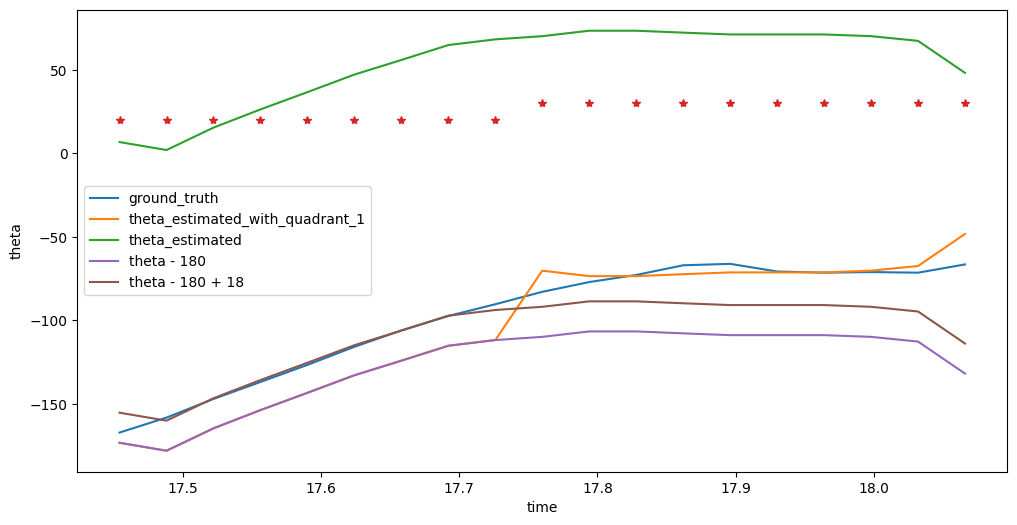

In [103]:
plt.close("all")
plt.figure(figsize=(12, 6))

sample_start=90
sample_end=109

theta_estimated_tuned = np.arcsin((w - min_width)/ (max_w - min_width))

time_sample = rod_9_ground_truth_times[sample_start:sample_end]
ground_truth_sample = rod_9_ground_truth_0[sample_start:sample_end] * 180 / np.pi
quadrant_estimation_sample = theta_estimated_with_quadrant_1[sample_start:sample_end] * 180 / np.pi
theta_estimated_sample = theta_estimated[sample_start:sample_end] * 180 / np.pi

plt.plot(time_sample, ground_truth_sample, label="ground_truth")
plt.plot(time_sample, quadrant_estimation_sample, label="theta_estimated_with_quadrant_1")
plt.plot(time_sample, theta_estimated_sample, label="theta_estimated")
plt.plot(time_sample, quadrants[sample_start:sample_end] * 10, "*")

calibrated_theta = -180 + theta_estimated_sample

offset= 18
calibrated_theta_offset = calibrated_theta + offset
plt.plot(time_sample, calibrated_theta, label=f"theta - 180")
plt.plot(time_sample, calibrated_theta_offset, label=f"theta - 180 + {offset}")

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

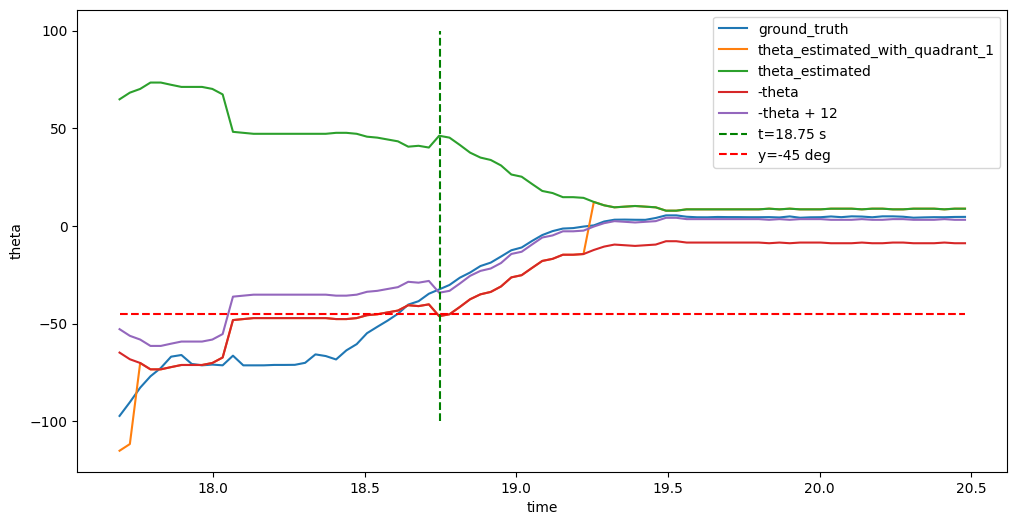

In [119]:
plt.close("all")
plt.figure(figsize=(12, 6))

sample_start=97
sample_end=180

theta_estimated_tuned = np.arcsin((w - min_width)/ (max_w - min_width))

time_sample = rod_9_ground_truth_times[sample_start:sample_end]
ground_truth_sample = rod_9_ground_truth_0[sample_start:sample_end] * 180 / np.pi
quadrant_estimation_sample = theta_estimated_with_quadrant_1[sample_start:sample_end] * 180 / np.pi
theta_estimated_sample = theta_estimated[sample_start:sample_end] * 180 / np.pi

plt.plot(time_sample, ground_truth_sample, label="ground_truth")
plt.plot(time_sample, quadrant_estimation_sample, label="theta_estimated_with_quadrant_1")
plt.plot(time_sample, theta_estimated_sample, label="theta_estimated")
# plt.plot(time_sample, quadrants[sample_start:sample_end] * 10, "*")

calibrated_theta = -theta_estimated_sample

offset= 12
calibrated_theta_offset = calibrated_theta + offset
plt.plot(time_sample, calibrated_theta, label=f"-theta")
plt.plot(time_sample, calibrated_theta_offset, label=f"-theta + {offset}")
plt.vlines(18.75, -100, 100, colors='g', linestyles='dashed',label='t=18.75 s')
plt.hlines(-45, time_sample[0], np.max(time_sample), colors='r', linestyles='dashed',label='y=-45 deg')

plt.xlabel("time") 
plt.ylabel("theta") 
plt.legend()
plt.show()

# Saving Bounding Boxes to Files

In [ ]:
# get image shape
#image = img.imread('/content/drive/My Drive/Colab Notebooks/rusty.png')
# matplotlib.pyplot.imread()
img_0 = np.asarray(Image.open(os.path.join(video_dir, frame_names[0])))
print(img_0.shape)
img_height,img_width = img_0.shape[0], img_0.shape[1]

In [ ]:
print(label_array.shape)
print(label_array[0][0])

### Apply scaling


In [ ]:
label_array[:,:,0]/=img_width
label_array[:,:,1]/=img_height
label_array[:,:,2]/=img_width
label_array[:,:,3]/=img_height


In [ ]:
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    frame_labels = label_array[out_frame_idx]
    for object_idx in range(len(frame_labels)):
        label = frame_labels[object_idx]
        cx = label[0]
        cy = label[1]
        w = label[2]
        h = label[3]
        # negative bounding box - not detected
        if(cx >= 0):
            draw_bounding_box_from_scaled_label(cx, cy, w, h, (img_width,img_height), plt.gca())
            plt.plot(cx,cy,'ro', markersize=2)

## Save labels to files

In [ ]:
output_dir = os.path.join(video_dir, "labels")
if os.path.exists(output_dir) == False:
    os.makedirs(output_dir)

In [ ]:
for frame_idx in range(0, len(frame_names)):
    frame_name = frame_names[frame_idx]
    frame_labels = label_array[frame_idx]
    write_label_data_to_file(frame_name, output_dir, frame_labels)

## Verify yolo-format annotations

In [ ]:
class_dictionary = {0: "ball", 1:"foosman"}

In [ ]:
# read files back and check bounding boxes
vis_frame_stride = 50
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    frame_name = frame_names[out_frame_idx]
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_name)))

    basename= os.path.splitext(os.path.basename(frame_name))[0]
    label_file_path = os.path.join(output_dir, basename + ".txt")

    annotation_list = []
    with open(label_file_path, "r") as file:
        annotation_list = file.read().split("\n")[:-1]
        annotation_list = [x.split(" ") for x in annotation_list]
        annotation_list = [[float(y) for y in x ] for x in annotation_list]
    
    for object_idx in range(len(annotation_list)):
        label = annotation_list[object_idx]
        class_id = label[0]
        cx = label[1]
        cy = label[2]
        w = label[3]
        h = label[4]
        draw_bounding_box_from_scaled_label(cx, cy, w, h, (img_width,img_height), plt.gca())
        cx_scaled = cx * img_width
        cy_scaled = cy * img_height
        plt.text(cx_scaled, cy_scaled - 10, class_dictionary[(int(class_id))], fontsize='xx-small')